# The `@reaction_network` DSL

A core feature of Catalyst is the `@reaction_network` domain-specific language (DSL) which allows users to create chemical reaction network (CRN). This is a so-called macro (part of "metaprogramming", a feature of only a few languages such as Julia and Lisp) which allows us to use custom code within Julia. Here, it allow us to use classic chemical reaction notation to create our models. This is then (at compile time, not run time!) converted into a `ReactionSystem` structure, storing all the information of a CRN.

Catalyst allows other ways to create CRNs (either programmatically or by loading from a file, top be described later). Later in this workshop we will also describe various options for simulating and analysing CRNs. 

## DSL basics

In [1]:
using Catalyst # Imports the Catalyst package for CRN model creation locally.

All information of the created model is encapsuled within a `@reaction_network begin ... end` statement. Each line correspond to a reaction, which is preceded by its rate. Here we create a reaction network consisting of two species (`X`, `Y`) that are converted to each others (at rates `k_X` and `k_Y`). The `rn = ...` part is used to store the resulting model in the variable `rn`.

In [2]:
rn = @reaction_network begin
    k_X, X --> Y
    k_Y, Y --> X
end

Model ##ReactionSystem#230
States (2):
  X(t)
  Y(t)
Parameters (2):
  k_X
  k_Y

In a notebook environment, the resulting crn is printed to the output (this can be disabled by ending the statement with `;`). If you instead want to see the ODEs produced by the CRN (according to the reaction rate equations), you can use the Latexify package and the `latexify(rn; form=:ode)` command:

In [3]:
using Latexify

In [4]:
latexify(rn; form=:ode)

L"$\begin{align}
\frac{\mathrm{d} X\left( t \right)}{\mathrm{d}t} =&  - k_{X} X\left( t \right) + k_{Y} Y\left( t \right) \\
\frac{\mathrm{d} Y\left( t \right)}{\mathrm{d}t} =& k_{X} X\left( t \right) - k_{Y} Y\left( t \right)
\end{align}
$"

Catalyst automatically extract the species, parameters, and reactions from the model. These can be checked using the `species`, `parameters`, and `reactions` functions:

In [5]:
species(rn)

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 X(t)
 Y(t)

In [6]:
parameters(rn)

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 k_X
 k_Y

In [7]:
reactions(rn)

2-element Vector{Reaction}:
 k_X, X --> Y
 k_Y, Y --> X

Remember, these reactions can be simulated using the notation we showed previously. First we create a `ODEProblem` by bundling:
- Our reaction network model.
- The initial conditions.
- The time span.
- The parameter values.

The initial conditions and parameter values are vectors, where each component's value is a pair of it's `Symbol` (its name preceded by a `:`) and its value. In Julia, `Pair`s are presented through `=>` arrows.

Here we create and simualte our model:

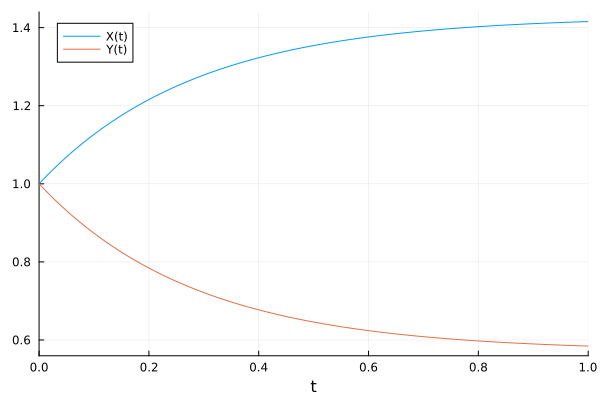

In [8]:
using DifferentialEquations, Plots
u0 = [:X => 1.0, :Y =>1.0]
tspan = (0.0, 1.0)
ps = [:k_X => 1.0, :k_Y => 2.5]
oprob = ODEProblem(rn, u0, tspan, ps)
sol = solve(oprob)
plot(sol)

## Various reactions types

Sometimes, some species are produced (or degraded). This can be represented through the empty set (using either `0` or `∅`). Here we create a simple production/degradation network:

In [9]:
rn_2 = @reaction_network begin
    p, 0 --> X    # X is produced .
    d, X --> 0    # X is degraded.
end

Model ##ReactionSystem#490
States (1):
  X(t)
Parameters (2):
  p
  d

A reactions substrates and/or products can contain multiple species. These are separated by a `+`. Here we create a simple binding/unbinding network (where `X` and `Y` reversibly bind to form `XY`).

In [10]:
rn_3 = @reaction_network begin
    kB, X + Y --> XY     # X and Y binds to form XY.
    kD, XY --> X + Y     # XY dissociates into X and Y.
end

Model ##ReactionSystem#496
States (3):
  X(t)
  Y(t)
  XY(t)
Parameters (2):
  kB
  kD

If multiple copies of a species participate in a reaction, the species can be preceded by a number indicating their stoichiometry. Here, we model a (reversible) dimerisation reaction (where 2 `X` molecules forms a single molecule `X2`).

In [12]:
rn_4 = @reaction_network begin
    kB, 2X --> X2     # X dimerises to form X2.
    kD, X2 --> 2X     # X2 dissociates into 2 copies of X.
end

Model ##ReactionSystem#508
States (2):
  X(t)
  X2(t)
Parameters (2):
  kB
  kD

These features can be combined freely, and stoichiometries can even be nested.

In [13]:
wacky_reaction = @reaction_network begin
    kW, 2X + 3(Y +2Z) --> 5v + W    
end

Model ##ReactionSystem#514
States (5):
  X(t)
  Y(t)
  Z(t)
  v(t)
⋮
Parameters (1):
  kW

## Bundling of similar reactions
Often, reaction networks contain reactions with similar structure. These can be bundled to create a more concise notation.

Reversible reactions can be modelled using a `<-->`. Here, the rate becomes a *tuple*, `(.,.)`, describing the *forward rate* followed by the *backward rate*. Here we create a production/degradation system ins a single like:

In [15]:
rn_5 = @reaction_network begin
    (p,d), 0 <--> X     
end

Model ##ReactionSystem#526
States (1):
  X(t)
Parameters (2):
  p
  d

This is identical to the notation we used previously (to create `rn_2`):

In [16]:
rn_5 = @reaction_network begin
    p, 0 --> X    # X is produced.
    d, X --> 0    # X is degraded.
end

Model ##ReactionSystem#532
States (1):
  X(t)
Parameters (2):
  p
  d

Tuples can also be applied to the substrate/product expressions to bundle similar terms. If we have a system of two species `X` and `Y` degrading at rates `dX` and `dY`, these reactions can be bundled accordingly:

In [17]:
rn_6 = @reaction_network begin
    (dX,dY), (X,Y) --> 0
end

Model ##ReactionSystem#538
States (2):
  X(t)
  Y(t)
Parameters (2):
  dX
  dY

If we wish both reactions to use the same rate `d`, this is possible:

In [18]:
rn_7 = @reaction_network begin
    d, (X,Y) --> 0
end

Model ##ReactionSystem#544
States (2):
  X(t)
  Y(t)
Parameters (1):
  d

If we wish, bundling can be used for both substrates and products. Here, we create two reactions one where `X1` is converted into `X2` (at rate `kX`) and one where `Y1` is converted into `Y2` (at rate `kY`).

In [19]:
rn_8 = @reaction_network begin
    (kX,kY), (X1,Y1) --> (X2,Y2)
end

Model ##ReactionSystem#550
States (4):
  X1(t)
  X2(t)
  Y1(t)
  Y2(t)
Parameters (2):
  kX
  kY

Again, bundling can be combined in various ways, using any number of terms, and also be combined with reversible reactions:

In [20]:
wacky_network = @reaction_network begin
    ((pX, pY, pZ),d), (0, Y0, Z0) <--> (X, Y, Z1+Z2)
end

Model ##ReactionSystem#556
States (6):
  X(t)
  Y0(t)
  Y(t)
  Z0(t)
⋮
Parameters (4):
  pX
  pY
  pZ
  d

The important rule is that the rate is first split into the forwards and backwards reactions, and bundling is then applied (in this case, bundling has probably been applied overzealously, making it harder to figure out what is going on).

## Using special symbols
Julia supports all unicode characters, and these can be used in reaction networks.

The empty set can be represented through the `∅` symbol, and most arrows (e.g. `→`, `↣`, `↔`, `⇄`, etc.) can be used. E.g here we recreates our production/degradation reaction using a fancier notation.

In [21]:
rn_9 = @reaction_network begin
    (p,d), ∅ ↔ X
end

Model ##ReactionSystem#562
States (1):
  X(t)
Parameters (2):
  p
  d

Such characters can also be used for species and parameters. E.g. I when I worked on the bacterial sigma factor V (*σᵛ*) I could create a reaction where it is produced at the basic rate *v₀* using

In [22]:
rn_10 = @reaction_network begin
    v₀, ∅ → σᵛ
end

Model ##ReactionSystem#568
States (1):
  σᵛ(t)
Parameters (1):
  v₀

If you want, backwards arrows can also be used:

In [23]:
rn_11 = @reaction_network begin
    d, 0 <-- X    # Equivalent to X --> 0
end

Model ##ReactionSystem#574
States (1):
  X(t)
Parameters (1):
  d

## Non-constant reaction rates
So far we have assumed that reaction rates are all constant parameters, however most expressions are permitted in the rate terms.

Let's assume that the activation of species `X` (converting it from an inactive form `X_i` to an active form `X_a`) is catalysed by the enzyme `E`. We can here put `E` in the reaction rate. In this case we will also add model production/degradation of `E`.

In [24]:
rn_12 = @reaction_network begin
    (p,d), 0 <--> E
    E, X_i --> X_a
end

Model ##ReactionSystem#580
States (3):
  E(t)
  X_i(t)
  X_a(t)
Parameters (2):
  p
  d

When can now check the rate of change in `X_a` in the corresponding ODE using `latexify(rn_12; form=:ode)`:

In [25]:
latexify(rn_12; form=:ode)

L"$\begin{align}
\frac{\mathrm{d} E\left( t \right)}{\mathrm{d}t} =& p - d E\left( t \right) \\
\frac{\mathrm{d} X_{i}\left( t \right)}{\mathrm{d}t} =&  - E\left( t \right) X_{i}\left( t \right) \\
\frac{\mathrm{d} X_{a}\left( t \right)}{\mathrm{d}t} =& E\left( t \right) X_{i}\left( t \right)
\end{align}
$"

If we want to also make the rate of the reaction `X_i --> X_a` scale with a parameter `k`, we can add that to the rate:

In [26]:
rn_13 = @reaction_network begin
    (p,d), 0 <--> E
    k*E, X_i --> X_a
end

Model ##ReactionSystem#586
States (3):
  E(t)
  X_i(t)
  X_a(t)
Parameters (3):
  p
  d
  k

In this case, an equivalent model can be achieved by adding `E` as a substrate and product to the reaction it catalyses:

In [27]:
rn_13 = @reaction_network begin
    (p,d), 0 <--> E
    k, X_i + E --> X_a + E
end

Model ##ReactionSystem#592
States (3):
  E(t)
  X_i(t)
  X_a(t)
Parameters (3):
  p
  d
  k

(in fact, if one carries out Gillespie simulations this as advantageous, as their speed can be increased if all reaction rates are constant)

The Michaelis-Menten (*mm(X,v,K) = v\*X/(X + K)*) and Hill (*hill(X,v,K,n) = v\*X^n/(X^n + K^n)*) functions are frequently used in systems biology. These are natively supported. Here we create a model where the rate of production of `X` is determined by a Hill function according to the concentration of a transcription factor (`T`, again we let `T` be produced and degraded at constant rate).

In [29]:
rn_14 = @reaction_network begin
    (p,d), 0 <--> T
    hill(T,v,K,n), 0 --> X
end

Model ##ReactionSystem#604
States (2):
  T(t)
  X(t)
Parameters (5):
  p
  d
  v
  K
⋮

A few other functions, such as repressive Michaelis-Menten and Hill functions are supported. It is also possible for the user to define their own functions and use them within the DSL.

In [30]:
my_function(k1,k2,E) = (k1+E)/(k2+E)
rn_15 = @reaction_network begin
    (p,d), 0 <--> E
    my_function(K1,K2,E), X_i --> X_a  # The name of the inputs to custom functions does not need to be the same as used to declare it.
end

Model ##ReactionSystem#610
States (3):
  E(t)
  X_i(t)
  X_a(t)
Parameters (4):
  p
  d
  K1
  K2

Generally, any valid expression can be used, and we can also use any normal Julia functions:

In [31]:
rn_16 = @reaction_network begin
    (p,d), 0 <--> E
    log(E) + k1^(1+k2), X_i --> X_a  
end

Model ##ReactionSystem#616
States (3):
  E(t)
  X_i(t)
  X_a(t)
Parameters (4):
  p
  d
  k1
  k2

The symbol `t` is reserved for time, and can be used to create time-dependent reactions. Here, `X` is produced at a cyclic rate (possibly modelling a circadian rythm):

In [32]:
rn_17 = @reaction_network begin
   (A + A*sin(2π/T*t+ϕ))/2, 0 --> X
end

Model ##ReactionSystem#622
States (1):
  X(t)
Parameters (3):
  A
  T
  ϕ

Finally, reaction rates can also be constants. Here `X` is produced at the constant rate `1`.

In [33]:
rn_17 = @reaction_network begin
    1, 0 --> X
 end

Model ##ReactionSystem#627
States (1):
  X(t)
Parameters (0):

## Advanced DSL usage
The DSL contain many more features for creating advanced models, here we will briefly describe a few.

Let us consider our previous catalysis model where `E` catalyses the reaction `X_i --> X_a`. What if we would want to model this without adding production/degradation for `E`? Then we would simply write 

In [34]:
rn_18 = @reaction_network begin
    E, X_i --> X_a  
end

Model ##ReactionSystem#633
States (2):
  X_i(t)
  X_a(t)
Parameters (1):
  E

However, if we then run `parameters(rn_18)` we will note that teh DSL have deducted `E` to be a parameter:

In [35]:
parameters(rn_18)

1-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 E

If we instead want to model `E` as a species we can explicitly designate this using the `@species` option (generally in the DSL, lines starting with `@...` indicate that some option is being used). We use this option, and then the `species` function to confirm that `E` is a species.

In [36]:
rn_19 = @reaction_network begin
    @species E(t)     # Have to add `(t)` to denote that E is a function of time. Almost always this is the case, but for e.g. a spatial system a species would also depend on some space variable(s).
    E, X_i --> X_a  
end
species(rn_19)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 E(t)
 X_i(t)
 X_a(t)

The `@species` option can also be used to set default values for that species. E.g. say that we typically want to use `E(0)=1.0` as an initial condition, then we use:

In [37]:
rn_20 = @reaction_network begin
    @species E(t)=1.0     
    E, X_i --> X_a  
end

Model ##ReactionSystem#643
States (3):
  E(t) [defaults to 1.0]
  X_i(t)
  X_a(t)
Parameters (0):

Next, we can simulate the model without supplying a value of E.

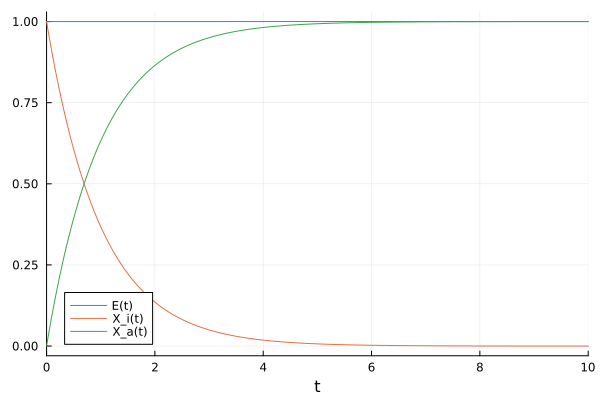

In [38]:
u0 = [:X_i => 1.0, :X_a => 0.0]
oprob = ODEProblem(rn_20, u0, (0.0, 10.0))    # We use the timespan (0.0, 10.0), since the model have no parameters, these don't have to be supplied.
sol = solve(oprob)
plot(sol)

In our final example, we show how the stoichiometric coefficients can also be set to parameters. Here, we have a dimerisation reaction where `N` molecules of `X` forms a single molecule `XN`:

In [39]:
rn_21 = @reaction_network begin
    kDi, N*X --> XN
end

Model ##ReactionSystem#873
States (2):
  X(t)
  XN(t)
Parameters (2):
  kDi
  N

We can now set `N` to e.g. `4` and simulate the model.

In [40]:
u0 = [:X => 1.0, :XN => 0.0]
ps = [:kDi => 1.0, :N => 4]
oprob = ODEProblem(rn_21, u0, (0.0, 10.0), ps)    # We use the timespan (0.0, 10.0).
sol = solve(oprob)
plot(sol)

MethodError: MethodError: no method matching factorial(::Float64)

Closest candidates are:
  factorial(!Matched::Int128)
   @ Base combinatorics.jl:25
  factorial(!Matched::BigInt)
   @ Base gmp.jl:708
  factorial(!Matched::Num)
   @ Symbolics ~/.julia/packages/Symbolics/lUFzg/src/register.jl:60
  ...
